In [6]:
# Set desired ticket ID
ticket_id = 'PY-1706'

# Request history XML
import requests
import auth
url = 'https://youtrack.jetbrains.com/rest/issue/{}/history'.format(ticket_id)
r = requests.get(url, auth=(auth.username,auth.password))

# Load the XML
import xml.etree.ElementTree as ET
tree = ET.fromstring(r.content)

# each version of the issue is in an 'issue' tag
from datetime import datetime
updates = [issue for issue in tree]
votes_over_time = {}


def ms_to_s(ms):
    return int(ms) // 1000


def field_by_name(parent, name):
    # YouTrack describes a version with a set of 'field' elements which are identified
    # by the 'name' attribute
    #
    # The updated time is stored in field[name=updated]
    xpath = "*[@name='{}']".format(name)
    fields = parent.findall(xpath)

    # Fields names are supposed to be unique, therefore take the 0th element
    # of the list of found fields

    if len(fields) < 1:
        raise KeyError('Could not find key: ' + name)

    return fields[0]


# extract updates over time from the XML
for update in updates:
    try:
        # "Updated" time is in field[name=updated]
        updated_time_field = field_by_name(update, 'updated')
        # The actual value is stored in a 'value' child element
        # with a 'SingleField' like 'updated', there's only one
        # 'value' child element
        updated_time_ms = updated_time_field.find('value').text

        # get the datetime
        updated = datetime.utcfromtimestamp(ms_to_s(updated_time_ms))

        voter_name_fields = field_by_name(update, 'voterName')
        voters = [field.text for field in voter_name_fields]

        votes_over_time[updated] = voters
    except KeyError as e:
        print(e)

In [7]:
import pandas as pd

counts_over_time = {}

for date, votes in votes_over_time.items():
    counts_over_time[pd.to_datetime(date)] = len(votes)

In [8]:
counts_series = pd.Series(list(counts_over_time.values()), index=counts_over_time.keys())

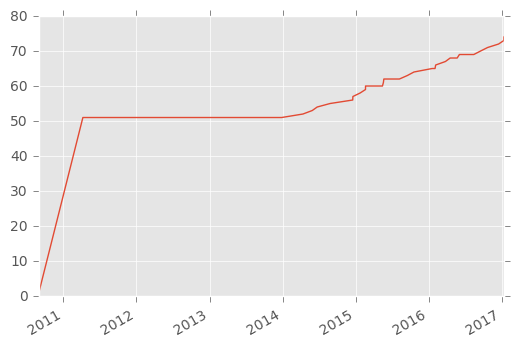

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

counts_series.plot()